In [456]:
import cProfile
import tensorflow as tf

import numpy as np
from scipy.io import loadmat
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

import keras
from keras import callbacks as callbacks_module
from keras.models import Model
from keras.layers import Input, Dense, Layer
from keras.losses import Loss, mse
from keras.optimizers import Optimizer, Adam
from keras.metrics import Mean
from keras.utils import  plot_model

from keras.engine import data_adapter
import keras.backend

np.random.seed(1234)
tf.random.set_seed(1234)

In [457]:
def printest(args, value):
    return print( "{} : \n {} \n".format(args, value) )

# PINN : One-Dimensional Shrödinger Equation

We aim to showcase the power of our proposed method in tackling partial differential equations (PDEs) that possess certain complexities, such as periodic boundary conditions, complex-valued solutions, and various forms of non-linearities. Specifically, we are looking into the nonlinear Schrödinger equation:

$$i \frac{\partial \psi}{\partial t} =-\frac{1}{2}\frac{\partial^2 \psi}{\partial x^2 } + |\psi|^2 \psi,~~~~ x \in [-5, 5], ~ t \in [0,\pi/2]$$

where $x$ is the spatial variable within the range of $[-5, 5]$, and $t$ is the time variable within the range of $[0,\pi/2]$. The solution $\psi(x, t)$ is complex-valued, which adds to the complexity of solving this equation.

In this case, the initial condition at time $t=0$ is defined by a hyperbolic secant profile:

$$\psi(x,0) = 2 \text{Sech}(x)$$

Furthermore, the periodic boundary conditions for this equation are defined as:
$$\psi(-5,t) =  \psi(5, t)$$

which means the solution at $x=-5$ and $x=5$ should be identical for all time $t$, reflecting a periodic behavior in the spatial dimension.

And we have the boundary condition describing the same derivative at both ends of the domain:

$$\psi(-5,t) =  \frac{\partial \psi(5, t)}{\partial x}$$

which implies that the rate of change of the solution with respect to $x$ is identical at $x=-5$ and $x=5$ for all time $t$. This ensures that there are no discontinuity ( or abrupt changes) in the solution's slope as we traverse the spatial domain.


# Optimizer L-BFGS-B : Class

In [458]:
class L_BFGS_B:
    def __init__(self, 
                 model , 
                 x_train, 
                 y_train, 
                 loss_func,
                 factr: float = 1e7, 
                 m: int=50, 
                 maxls: int=50, 
                 maxiter: int=5000):
        """
        Initialize the L-BFGS-B optimizer with given model, data, loss function, and optimization parameters.

        Args:
            model: The model to be optimized.
            x_train: The input data (features) for training.
            y_train: The output data (labels) for training.
            loss_func: The loss function to be minimized during training.
            factr: The optimization parameter for L-BFGS-B (default: 1e7).
            m: The number of limited memory vectors for L-BFGS-B (default: 50).
            maxls: The maximum number of line search steps for L-BFGS-B (default: 50).
            maxiter: The maximum number of iterations for L-BFGS-B (default: 5000).
        """
   
        self.model = model
        self.loss_func = loss_func
        self.loss_tracker = None
        self.current_step = 0
        
        self.x_train = [ tf.constant(x, dtype=tf.float32) for x in x_train ]
        self.y_train = tf.constant(y_train, dtype=tf.float32)

        # Store optimization parameters
        self.factr = factr
        self.m = m
        self.maxls = maxls 
        self.maxiter = maxiter
        self.metrics = ['loss']

        # Initialize the progress bar for displaying optimization progress
        self.progbar = tf.keras.callbacks.ProgbarLogger(
            count_mode='steps', stateful_metrics=self.metrics)
        self.progbar.set_params( {
            'verbose':1, 'epochs':self.maxiter, 'steps':1, 'metrics':self.metrics})
   
    def set_weights(self, weights_1d):
        """
        Set the model's weights using a 1D array of weights.

        Args:
            weights_1d: A 1D numpy array representing the weights of the model.
        """

        #Set the model's weights using a 1D array of weights
        weights_shapes = [ w.shape for w in self.model.get_weights() ]
        n = [0] + [ np.prod(shape) for shape in weights_shapes ] 
        partition = np.cumsum(n) 
        weights = [ weights_1d[from_part:to_part].reshape(shape)
                        for from_part, to_part, shape 
                        in zip(partition[:-1], partition[1:], weights_shapes) ]
                        
        self.model.set_weights(weights)
    
    @tf.function
    def tf_evaluate(self, x, y):
        """
        Compute the model's loss and gradients for the given input (x) and output (y) tensors.

        Args:
            x: Input tensor.
            y: Output tensor.

        Returns:
            loss: The computed loss.
            grads: The computed gradients.
        """
        with tf.GradientTape() as tape:
            
            y_pred = self.model(x)
            loss = self.loss_func(y,  y_pred)
        grads = tape.gradient(loss, self.model.trainable_weights)
        return loss, grads
    
    def evaluate(self, weights_1d):
        """
        Evaluate the model's loss and gradients using the given 1D array of weights.

        Args:
            weights_1d: A 1D numpy array representing the weights of the model.

        Returns:
            loss: The computed loss.
            grads_concat: The computed gradients concatenated as a 1D numpy array.
        """
        # Evaluate the model's loss and gradients using the given 1D array of weights
        self.set_weights(weights_1d)
        loss, grads = self.tf_evaluate(self.x_train, self.y_train)

        # Convert the loss and gradients to numpy arrays for use with the L-BFGS-B optimizer
        loss = loss.numpy().astype('float64') 
        grads_concat = np.concatenate([ g.numpy().flatten() for g in grads ]).astype('float64')
        self.loss_tracker = loss
        return loss, grads_concat
    
    def callback(self,_):
        """
        Callback function to execute custom actions during optimization.

        Args:
            _: Unused argument for compatibility with the optimizer's callback signature.
        """

        # Update the progress bar at the specified interval
        update_interval = 1
        if self.current_step % update_interval == 0:
            self.progbar.on_epoch_begin(self.current_step)
            loss = self.loss_tracker
            self.progbar.on_epoch_end(self.current_step, logs= {"loss":loss})
            
        self.current_step += 1

    def train(self):
        """
        Train the model using the L-BFGS-B optimization algorithm.
        """

        self.model(self.x_train)
        initial_weights = np.concatenate([ w.flatten() for w in self.model.get_weights() ])
        
        print('Optimizer: L-BFGS-B (maxiter={})'.format(self.maxiter))

        self.progbar.on_train_begin()
        # Train the model using L-BFGS-B optimization
        fmin_l_bfgs_b(  func=self.evaluate, x0=initial_weights, factr=self.factr,
                        m=self.m, maxls=self.maxls, maxiter=self.maxiter, callback=self.callback )
        self.progbar.on_train_end()

# Dense Neural Network (DNN) : Model

In [459]:
class DNN(Model):
    def __init__(self,
                 layer_units: list = [100, 100, 100, 100],
                 output_unit: int = 2,
                 activation_func: str = 'tanh',
                 initializer: str = "he_normal",
                 name="DNN"):
        """
        Initialize the DNN (Deep Neural Network) layer.

        Args:
            layer_units: A list of integers representing the number of units in each hidden layer .
            output_unit: An integer representing the number of units in the output layer .
            activation_func: A string representing the activation function used in the hidden layers .
            initializer: A string representing the kernel initializer used for the layers .
            name: A string representing the name of the layer.
        """
        super().__init__(name=name)

        self.units = layer_units
        self.output_unit = output_unit
        self.activation_func = activation_func
        self.initializer = initializer

        # Hidden layers
        self.hidden_layer = []
        count = 0
        for unit in layer_units:
            self.hidden_layer.append(Dense(units=unit,
                                           kernel_initializer=self.initializer,
                                           activation=activation_func,
                                           name='Hidden_{}'.format(count)))
            count += 1

        # Output layer
        self.output_layer = Dense(units=output_unit,
                                  kernel_initializer=self.initializer,
                                  name="Output")

    def call(self, x):
        """
        Compute the forward pass of the DNN layer.

        Args:
            x: A tensor of shape (batch_size, input_dim), where input_dim is the dimension of the input features.

        Returns:
            x: A tensor of shape (batch_size, output_unit), containing the output of the DNN layer.
        """

        for hidden in self.hidden_layer:
            x = hidden(x)

        x = self.output_layer(x)

        return x

# Automatic Diff: Layer

In [460]:
class AutomaticDiff(Layer):
    
    def __init__(self, dnn: DNN,
                         name: str = 'AutomaticDiff'):
        """
        Initialize the AutomaticDiff layer.
        
        Args:
            dnn: A deep neural network (DNN) used for computing derivatives.
            nu: A float representing the viscosity coefficient in Burgers' equation.
            name: A string representing the name of this layer. Defaults to 'AutomaticDiff'.
        """

        self.dnn = dnn
        super().__init__(name = name)

    def call(self, inputs):
        """
        Compute the residual of Burgers' equation using the input tensor xt.
        
        This method computes the first and second derivatives of the DNN with respect to the input tensor, and then
        calculates the residual of Burgers' equation using these derivatives.

        Args:
            xt: A tensor representing the input data (spatial and temporal points).

        Returns:
            residual: A tensor representing the residual of Burgers' equation.
        """
        xt0, xt, xt_ub, xt_lb = inputs
        # Jacobian outputs shape: (batch, units, input_size)
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(xt)
            with tf.GradientTape(persistent=True) as g:
                g.watch([xt0, xt, xt_ub, xt_lb])
                uv = self.dnn(xt) 
                uv_lb = self.dnn(xt_lb)  
                uv_ub = self.dnn(xt_ub)
            duv_dxt = g.batch_jacobian(uv, xt)
            duv_dxt_lb = g.batch_jacobian(uv_lb, xt_lb)
            duv_dxt_ub = g.batch_jacobian(uv_ub, xt_ub)
        d2uv_dxt2 = g.batch_jacobian(duv_dxt, xt)

        du_dt = duv_dxt[:,0,1:2]
        dv_dt = duv_dxt[:,1,1:2]
        d2u_dx2 = d2uv_dxt2[:,0,0:1]
        d2v_dx2 = d2uv_dxt2[:,1,0:1]
        u = uv[:,0:1]
        v = uv[:,1:2]

        f_u = du_dt + 0.5*d2v_dx2 + (u**2 + v**2)*v
        f_v = dv_dt - 0.5*d2u_dx2 - (u**2 + v**2)*u  

        return [uv_lb, duv_dxt_lb, uv_ub, duv_dxt_ub, f_u, f_v]

# Physics Informed Neural Network (PINN): Model

In [461]:
class PINN(Model):
    def __init__(self,
                  dnn: DNN,
                  name: str =  'PINN'):
        super().__init__(name = name)

        """
        Initialize the Physics-Informed Neural Network (PINN) model.

        Args:
            dnn (DNN): A deep neural network object to use as the base model.
            nu (float, optional): The parameter nu used in the PDE equation. Defaults to 0.01/np.pi.
            name (str, optional): The name of the model. Defaults to 'PINN'.
        """
        
        self.dnn = dnn
        self.auto_diff = AutomaticDiff(self.dnn)


    @property
    def metrics(self):
        """
        Return the list of loss trackers used in the model.
        """
        if not hasattr(self, 'loss_tracker'):
            self.loss_tracker = Mean(name="loss")
        return [self.loss_tracker] 

    def call(self, x_train): 
        """
        Compute the model outputs for the given inputs.

        Args:
            x_train (tuple): A tuple containing the input data for equation, initial conditions, and boundary conditions.

        Returns:
            tuple: The computed residuals, initial conditions, and boundary conditions.
        """ 
        xt0, _, _, _ = x_train     
        uv0 = self.dnn(xt0) 
        uv_lb, duv_dxt_lb, uv_ub, duv_dxt_ub, f_u, f_v = self.auto_diff(x_train)

        return [uv0, uv_lb, duv_dxt_lb, uv_ub, duv_dxt_ub, f_u, f_v]
    
    def train_step(self, data):
        """
        Train the model for one step using the given input and target data.

        Args:
            data (tuple): A tuple containing the input data and target data.

        Returns:
            dict: A dictionary containing the loss value for this training step.
        """
        return self._process_step(data)
    
    @tf.function
    def tf_evaluate_loss_grads(self, x, y):
        """
        Evaluate the loss and gradients for the given input and target data.

        Args:
            x (tf.Tensor): The input data.
            y (tf.Tensor): The target data.

        Returns:
            tuple: The loss and gradients for the given input and target data.
        """
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compute_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_weights)
        return loss, grads
    
    # Helper function to process one batch of data
    def _process_step(self, data):
        """
        Helper function to process one batch of data.

        Args:
            data (tuple): A tuple containing the input data and target data.

        Returns:
            dict: A dictionary containing the loss value for this training step.
        """
        x_train, y_train = data
        loss, grads = self.tf_evaluate_loss_grads(x_train, y_train)
        #if no other optimizer is choose and use_l_bfgs_b_optimizer = True
        # then self.optimizer = None and this is skipped
        if self.optimizer != None:
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update the loss trackers
        self.loss_tracker.update_state(loss)
    
        return {"loss": self.loss_tracker.result()}
    
    def compute_loss(self, y_train, y_pred):
        """
        Compute the loss between the predicted and target values.

        Args:
            y_train (tf.Tensor): The target data.
            y_pred (tf.Tensor): The predicted data.

        Returns:
            tf.Tensor: The computed loss.
        """
        uv0, uv_lb, duv_dxt_lb, uv_ub, duv_dxt_ub, f_u, f_v = y_pred
        # investigate why y_train is transformed into a list
        uv0_true = y_train

        du_dx_lb = duv_dxt_lb[:,0,0:1]
        dv_dx_lb = duv_dxt_lb[:,1,0:1]
        du_dx_ub = duv_dxt_ub[:,0,0:1]
        dv_dx_ub = duv_dxt_ub[:,1,0:1]
        u_lb = uv_lb[:,0:1]
        v_lb = uv_lb[:,1:2]
        u_ub = uv_ub[:,0:1]
        v_ub = uv_ub[:,1:2]
        u0 = uv0[:,0:1]
        v0 = uv0[:,1:2]
        u0_true = uv0_true[:,0:1]
        v0_true = uv0_true[:,1:2]

        loss = tf.reduce_mean(tf.square(u0 - u0_true)) + \
            tf.reduce_mean(tf.square(v0 - v0_true)) + \
            tf.reduce_mean(tf.square(u_lb - u_ub)) + \
            tf.reduce_mean(tf.square(v_lb - v_ub)) + \
            tf.reduce_mean(tf.square(du_dx_lb - du_dx_ub)) + \
            tf.reduce_mean(tf.square(dv_dx_lb - dv_dx_ub)) + \
            tf.reduce_mean(tf.square(f_u)) + \
            tf.reduce_mean(tf.square(f_v))
        return loss
        

    def custom_fit(self, x, y, epochs = 1, batch_size = None, shuffle = True, use_l_bfgs_b_optimizer = True, factr=1e7, m=50, maxls=50, maxiter=5000):
        """
        Custom fit function for the PINN model. This method allows the use of the L-BFGS-B optimizer, which is a popular choice for
        solving partial differential equations with neural networks due to its ability to handle large-scale optimization problems
        efficiently. By providing the option to use the L-BFGS-B optimizer, this custom fit function enables better convergence
        and potentially faster training for the PINN model.

        The input data (x) and target data (y) should be provided as tuples of tensors, where each element in the tuple corresponds
        to a specific type of training data:

        x_train = (xt, xt_0, xt_bnd)
        y_train = (r, u_0, u_bnd)

        Args:
            x (tuple): The input data as a tuple of tensors (xt, xt_0, xt_bnd).
            y (tuple): The target data as a tuple of tensors (r, u_0, u_bnd).
            epochs (int, optional): The number of epochs to train the model. Defaults to 1.
            batch_size (int, optional): The batch size to use during training. Defaults to None.
            shuffle (bool, optional): Whether to shuffle the data before each epoch. Defaults to True.
            use_l_bfgs_b_optimizer (bool, optional): Whether to use the L-BFGS-B optimizer for training. Defaults to True.
            factr (float, optional): The L-BFGS-B factr parameter. Defaults to 1e7.
            m (int, optional): The L-BFGS-B m parameter. Defaults to 50.
            maxls (int, optional): The L-BFGS-B maxls parameter. Defaults to 50.
            maxiter (int, optional): The L-BFGS-B maxiter parameter. Defaults to 5000.

        Returns:
            if use_l_bfgs_b_optimizer = False return tf.keras.callbacks.History: A History object that records the training loss values.
        """
        
        if use_l_bfgs_b_optimizer:
            # Custom L_BFGS_B  Optimizer
            l_bfgs_b_optimizer = L_BFGS_B(model = self, x_train=x, y_train=y, loss_func = self.compute_loss, factr=factr, m=m, maxls=maxls, maxiter=maxiter)
            l_bfgs_b_optimizer.train()

        # Only used if using l_bfgs_b_optimizer = False
        if not use_l_bfgs_b_optimizer:
            # I use data_adapter.get_data_handler similar to the standard fit method
            # Create a data handler using the input data and provided parameters
            data_handler = data_adapter.get_data_handler(
                                            x=x,
                                            y=y,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            shuffle=shuffle,
                                            model=self
                                        )
            verbose = 1
            # I use callbacks_module.CallbackList similar to the standard fit method
            # Create a callback list to manage the training process and display progress
            callbacks = callbacks_module.CallbackList(
                            None,
                            add_history=True,
                            add_progbar=verbose != 0,
                            model=self,
                            verbose=verbose,
                            epochs = epochs,
                            steps=data_handler.inferred_steps,
                        )
            
            callbacks.on_train_begin()
            # data_handler.enumerate_epochs generate a iterator and epochs
            for epoch, data_iterator in data_handler.enumerate_epochs():
                self.reset_metrics()  
                callbacks.on_epoch_begin(epoch)  
                for step in data_handler.steps():            
                    callbacks.on_train_batch_begin(step)
                    # Get the current batch of data from the data_iterator
                    (x_batch, y_batch) = next(data_iterator)
                    # Perform one training step with the current batch of data
                    logs = self.train_step((x_batch, y_batch))     
                    callbacks.on_train_batch_end(step, logs)   
                
                # End the current epoch and update the logs             
                callbacks.on_epoch_end(epoch, logs)
            callbacks.on_train_end()
            return callbacks._history

# Main

In [487]:
lower_boundary = np.array([-5.0, 0.0])
upper_boundary = np.array([5.0, np.pi/2])

# Number of initial and boundary data points
#n_0 = 50    # initial data points
#n_bdr = 50  # boundary points

# Number of collocation(internal) points for enforcing PDE
n_c = 1500
n_0 = n_c
n_bdr = n_c

data = loadmat('./Data/NLS.mat')
t_exact = data['tt'].T
x_exact = data['x'].T  
X, T = np.meshgrid(x_exact,t_exact) 
xt = np.hstack((T.flatten()[:,None], X.flatten()[:,None]))
x = xt[:,0:1]
t = xt[:,1:2]
Exact = data['uu']
psi_real = np.real(Exact)
psi_img = np.imag(Exact)
psi_exact = np.sqrt(psi_real**2 + psi_img**2)

u = psi_real.flatten()[:, None]
v = psi_img.flatten()[:, None]
psi = psi_exact.flatten()[:, None]

# Select n_0 random spatial locations for initial conditions
idx = np.random.choice(xt.shape[0], n_0, replace=False)
x0 = x[idx,:]     # Initial spatial locations
xt0 = np.concatenate((x0, 0*x0), 1)  # (x0, 0)
u0 = u[idx,0:1]   # Initial real part of solution
v0 = v[idx,0:1]   # Initial imaginary part of solution
uv0 = np.concatenate([u0, v0], 1)

# Select n_b random time locations for boundary conditions
idx = np.random.choice(xt.shape[0], n_bdr, replace=False)
t_bdr = t[idx,:]
xt_lb = np.concatenate((0*t_bdr + lower_boundary[0], t_bdr), 1)    # (lb[0], tb)
xt_ub = np.concatenate((0*t_bdr + upper_boundary[0], t_bdr), 1)    # (ub[0], tb)

samples_square = np.random.rand(n_c, 2)
xt_c = lower_boundary + (upper_boundary - lower_boundary) * samples_square

x_train = [xt0, xt_c, xt_ub, xt_lb]
y_train = uv0

In [494]:
dnn = DNN()
pinn = PINN(dnn)
#pinn.compile(optimizer=Adam(learning_rate=0.001))
pinn.custom_fit(x_train, y_train, batch_size = 32, epochs = 100, use_l_bfgs_b_optimizer = True)
#pinn.custom_fit(x_train, y_train, use_l_bfgs_b_optimizer = True)

Optimizer: L-BFGS-B (maxiter=5000)
Epoch 1/5000
1/1 [==============================] - 0s 999us/step - loss: 3.2366
Epoch 2/5000
1/1 [==============================] - 0s 1ms/step - loss: 1.9225
Epoch 3/5000
1/1 [==============================] - 0s 999us/step - loss: 1.2385
Epoch 4/5000
1/1 [==============================] - 0s 999us/step - loss: 0.7893
Epoch 5/5000
1/1 [==============================] - 0s 0s/step - loss: 0.7423
Epoch 6/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.7234
Epoch 7/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.7039
Epoch 8/5000
1/1 [==============================] - 0s 999us/step - loss: 0.6789
Epoch 9/5000
1/1 [==============================] - 0s 1000us/step - loss: 0.6558
Epoch 10/5000
1/1 [==============================] - 0s 999us/step - loss: 0.6497
Epoch 11/5000
1/1 [==============================] - 0s 1000us/step - loss: 0.6431
Epoch 12/5000
1/1 [==============================] - 0s 491us/step - loss: 0.64

# Plots

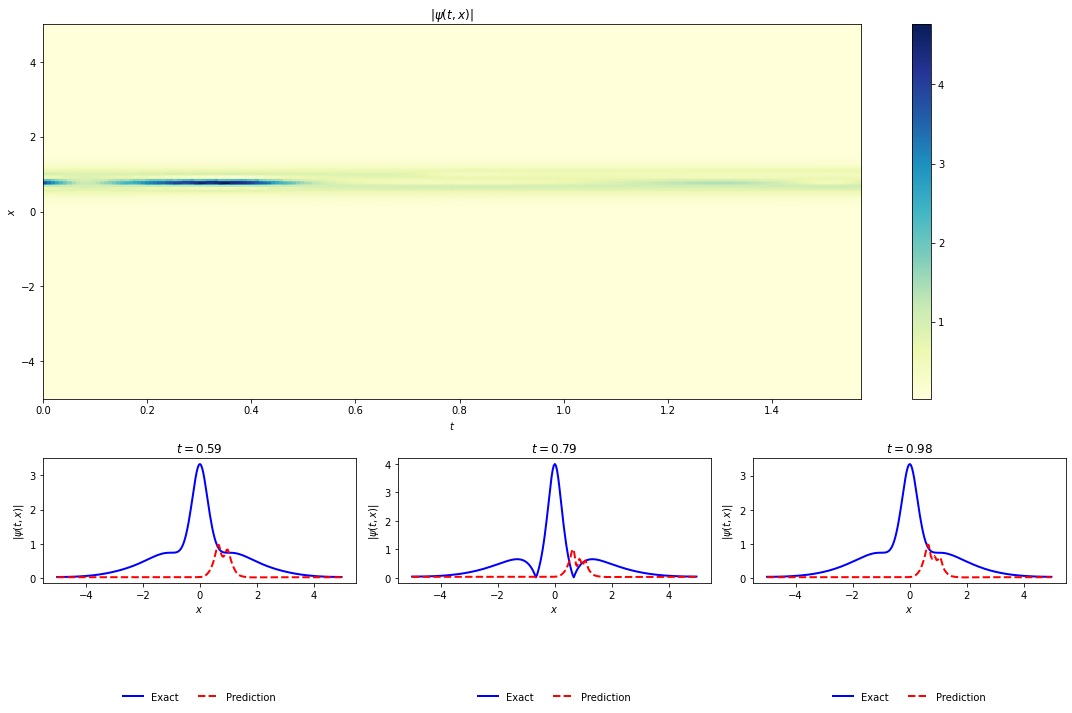

In [495]:
x_values = np.linspace(lower_boundary[0], upper_boundary[0], 100)  # 100 points between -5 and 5
t_values = np.linspace(lower_boundary[1], upper_boundary[1], 100)  # 100 points between 0 and pi/2
x_grid, t_grid = np.meshgrid(x_values, t_values)
xt_grid = np.hstack((x_grid.flatten()[:, None], t_grid.flatten()[:, None]))

uv_grid = dnn(xt_grid)
u_grid, v_grid = uv_grid[:,0:1], uv_grid[:,1:2]
psi_pred = np.sqrt(u_grid**2 + v_grid**2)

psi_pred_2D = griddata(xt_grid, psi_pred.flatten(), (X, T), method='cubic')

fig = plt.figure(figsize=(15, 10))

gs = GridSpec(2, 3, height_ratios=[3, 1]) 

# Plot the amplitude |ψ(t,x)| as a heatmap
ax0 = plt.subplot(gs[0, :])  # Span all columns
img = ax0.imshow(psi_pred_2D.T, interpolation='nearest', cmap='YlGnBu', 
           extent=[lower_boundary[1], upper_boundary[1], lower_boundary[0], upper_boundary[0]], 
           origin='lower', aspect='auto')
fig.colorbar(img, ax=ax0)
# plot initial points 
#ax0.plot(xt0[:,1:2], xt0[:,0:1], 'kx', markersize = 7, clip_on = False, label = 'Initial conditions')
# Plot boundary points
#ax0.plot(xt_lb[:,1:2], xt_lb[:,0:1], 'ro', markersize = 4, clip_on = False, label = 'Boundary points')
#ax0.plot(xt_ub[:,1:2], xt_ub[:,0:1], 'ro', markersize = 4, clip_on = False)
#ax0.legend(['Data (%d points)' % (xt0.shape[0]+xt_lb.shape[0]+xt_ub.shape[0])])
ax0.set_xlabel('$t$')
ax0.set_ylabel('$x$')
ax0.set_title('$|ψ(t,x)|$')

# Plot slices of |h(t,x)| for specific time points
times = [75, 100, 125]  # time indices to plot

for i, t_idx in enumerate(times):
    ax = plt.subplot(gs[1, i])  # Change subplot index here
    ax.plot(x_exact, psi_exact[:,t_idx], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x_exact, psi_pred_2D.T[:,t_idx], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$|ψ(t,x)|$')
    ax.set_title('$t = %.2f$' % (t_exact[t_idx]))
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)

plt.tight_layout()
plt.show()



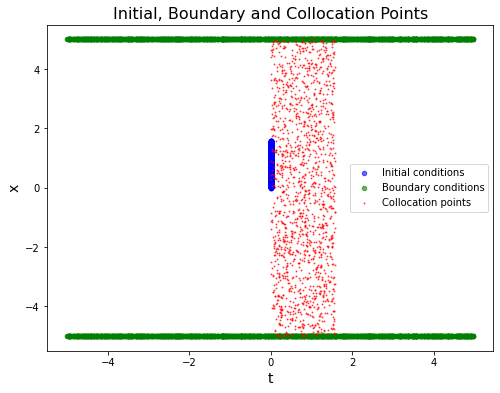

In [496]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot initial condition points
ax.scatter(np.zeros_like(x0), x0, color='blue', s=20, alpha=0.6, label='Initial conditions')

# Plot boundary condition points
ax.scatter(t_bdr, np.full_like(t_bdr, -5.0), color='green', s=20, alpha=0.6, label='Boundary conditions')
ax.scatter(t_bdr,np.full_like(t_bdr, 5.0), color='green', s=20, alpha=0.6)

# Plot collocation points
ax.scatter(xt_c[:,1], xt_c[:,0], color='red', s=1, alpha=0.6, label='Collocation points')

# Set labels and title
ax.set_xlabel('t', fontsize=14)
ax.set_ylabel('x', fontsize=14)
ax.set_title('Initial, Boundary and Collocation Points', fontsize=16)
ax.legend()

# Display plot
plt.show()
